# Week 3b: Filtering, Hilbert Transform, and Coherence

This notebook builds on the spectral analysis techniques from Week 3a. There,
we learned to decompose LFP signals into their frequency components using the
Fourier transform and multitaper methods. Now we move from *observing*
frequency content to *manipulating* and *relating* signals:

1. **Bandpass filtering** — isolating a specific frequency band from a signal
2. **Hilbert transform** — extracting instantaneous phase and amplitude
3. **Spectral coherence** — measuring the consistency of the phase relationship
   between two LFP signals across time

Using the same dataset from Weeks 1–3a ([Petersen & Buzsáki, 2020](https://pmc.ncbi.nlm.nih.gov/articles/PMC7442698/)),
we'll extract the theta rhythm from hippocampal LFP, compute its
instantaneous phase and power, and measure coherence between electrode
channels.

## Learning Objectives

By the end of this notebook, you will be able to:

1. Design and apply bandpass filters using `scipy.signal`
2. Understand the difference between FIR and IIR filters
3. Understand causal vs. zero-phase (non-causal) filtering
4. Extract instantaneous phase and amplitude using the Hilbert transform
5. Compute spectral coherence between two LFP signals
6. Interpret coherence as a measure of phase consistency

## Setup

In [1]:
# Install dependencies (required for Google Colab)
import subprocess
import sys

if "google.colab" in sys.modules:
    subprocess.check_call(
        [
            sys.executable,
            "-m",
            "pip",
            "install",
            "-q",
            "pynwb",
            "hdmf",
            "dandi",
            "remfile",
            "h5py",
            "fsspec",
            "aiohttp",
            "requests",
            "spectral-connectivity",
        ]
    )

In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from dandi.dandiapi import DandiAPIClient
from pynwb import NWBHDF5IO
from remfile import File as RemoteFile
from scipy.signal import butter, filtfilt, firwin, freqz, hilbert, sosfilt, sosfreqz
from spectral_connectivity import Connectivity, Multitaper

## Load Data from DANDI

We need two files for this analysis:
1. The **behavior file** containing speed data (to identify running epochs)
2. The **LFP file** containing the raw electrophysiology data

In [3]:
# Define the dataset location on DANDI
DANDISET_ID = "000059"
DANDISET_VERSION = "0.230907.2101"

# Behavior file (contains speed)
BEHAVIOR_ASSET_PATH = (
    "sub-MS22/"
    "sub-MS22_ses-Peter-MS22-180629-110319-concat_desc-processed_behavior+ecephys.nwb"
)

# LFP file (contains raw electrophysiology)
LFP_ASSET_PATH = (
    "sub-MS22/"
    "sub-MS22_ses-Peter-MS22-180629-110319-concat_desc-raw_ecephys.nwb"
)

### Load Behavior Data (Speed)

In [4]:
# Connect to DANDI and get the streaming URL for behavior file
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(DANDISET_ID, DANDISET_VERSION)
    behavior_asset = dandiset.get_asset_by_path(BEHAVIOR_ASSET_PATH)
    behavior_s3_url = behavior_asset.get_content_url(follow_redirects=1, strip_query=True)

print(f"Behavior file: {BEHAVIOR_ASSET_PATH}")
print(f"Streaming from: {behavior_s3_url[:80]}...")

Behavior file: sub-MS22/sub-MS22_ses-Peter-MS22-180629-110319-concat_desc-processed_behavior+ecephys.nwb
Streaming from: https://dandiarchive.s3.amazonaws.com/blobs/075/b32/075b32be-1c44-4e2f-8a91-3eeb...


In [5]:
# Open the behavior NWB file
behavior_remote_file = RemoteFile(behavior_s3_url)
behavior_h5_file = h5py.File(behavior_remote_file, "r")
behavior_io = NWBHDF5IO(file=behavior_h5_file, load_namespaces=True)
behavior_nwbfile = behavior_io.read()

print(f"Session: {behavior_nwbfile.identifier}")

Session: 7931d1a7-09c5-457f-9f0a-22d952d8b818


In [6]:
# Extract speed data
behavior_module = behavior_nwbfile.processing["behavior"]

speed_interface = next(
    interface
    for name, interface in behavior_module.data_interfaces.items()
    if "speed" in name.lower()
)

speed_data = speed_interface.data[:]
speed_timestamps = speed_interface.timestamps[:]

print(f"Speed data shape: {speed_data.shape}")
print(f"Speed time range: {speed_timestamps[0]:.1f} - {speed_timestamps[-1]:.1f} s")

Speed data shape: (198664,)
Speed time range: 6348.1 - 8003.6 s


In [7]:
# Get electrodes info (for theta reference channel)
electrodes_df = behavior_nwbfile.electrodes.to_dataframe()

if "theta_reference" in electrodes_df.columns:
    theta_ref_indices = np.nonzero(electrodes_df["theta_reference"].values)[0]
    if len(theta_ref_indices) > 0:
        theta_ref_channel = theta_ref_indices[0]
        print(f"Theta reference channel: {theta_ref_channel}")
else:
    theta_ref_channel = 0
    print(f"No theta reference found, using channel {theta_ref_channel}")

Theta reference channel: 6


### Load LFP Data

In [8]:
# Get streaming URL for LFP file
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(DANDISET_ID, DANDISET_VERSION)
    lfp_asset = dandiset.get_asset_by_path(LFP_ASSET_PATH)
    lfp_s3_url = lfp_asset.get_content_url(follow_redirects=1, strip_query=True)

print(f"LFP file: {LFP_ASSET_PATH}")
print(f"Streaming from: {lfp_s3_url[:80]}...")

LFP file: sub-MS22/sub-MS22_ses-Peter-MS22-180629-110319-concat_desc-raw_ecephys.nwb
Streaming from: https://dandiarchive.s3.amazonaws.com/blobs/5ff/17f/5ff17f89-382d-400b-8501-028f...


In [9]:
# Open the LFP NWB file
lfp_remote_file = RemoteFile(lfp_s3_url)
lfp_h5_file = h5py.File(lfp_remote_file, "r")
lfp_io = NWBHDF5IO(file=lfp_h5_file, load_namespaces=True)
lfp_nwbfile = lfp_io.read()

print(f"LFP Session: {lfp_nwbfile.identifier}")

LFP Session: 50906443-9caf-41e1-aaa7-c07c4dbede84


In [10]:
# Get LFP electrical series
lfp_electrical_series = next(iter(lfp_nwbfile.acquisition.values()))

lfp_rate = lfp_electrical_series.rate
n_channels = lfp_electrical_series.data.shape[1]

print(f"LFP data shape: {lfp_electrical_series.data.shape}")
print(f"LFP sampling rate: {lfp_rate} Hz")
print(f"Number of channels: {n_channels}")

LFP data shape: (243000720, 128)
LFP sampling rate: 20000.0 Hz
Number of channels: 128


In [11]:
# Load a segment of LFP aligned to the behavior epoch
# We'll use 60 seconds during active running for clean theta
ANALYSIS_DURATION = 60  # seconds
behavior_start_sample = int(speed_timestamps[0] * lfp_rate)
n_analysis = int(ANALYSIS_DURATION * lfp_rate)

# Load two channels: the theta reference and a nearby channel for coherence
second_channel = min(theta_ref_channel + 1, n_channels - 1)

lfp_ch1 = lfp_electrical_series.data[
    behavior_start_sample : behavior_start_sample + n_analysis, theta_ref_channel
]
lfp_ch2 = lfp_electrical_series.data[
    behavior_start_sample : behavior_start_sample + n_analysis, second_channel
]
lfp_time = np.arange(n_analysis) / lfp_rate

print(f"Loaded {ANALYSIS_DURATION}s of LFP from channels {theta_ref_channel} and {second_channel}")
print(f"Sample shape: {lfp_ch1.shape}")

Loaded 60s of LFP from channels 6 and 7
Sample shape: (1200000,)


## Part 1: Bandpass Filters

In Week 3a we decomposed LFP into its frequency components using the Fourier
transform. Sometimes we want to go the other direction: **isolate a specific
frequency band** from the raw signal. This is what a bandpass filter does.

A **bandpass filter** keeps signal components in a frequency range (e.g.,
theta: 4–12 Hz) and suppresses components outside it. Related filter types:

- **Lowpass**: keeps frequencies below a cutoff
- **Highpass**: keeps frequencies above a cutoff
- **Bandstop** (notch): removes a specific frequency band (e.g., 60 Hz line noise)

### Building Intuition with Synthetic Signals

Let's start with a signal where we know the answer: a mixture of a slow
oscillation (6 Hz, theta-like) and a fast oscillation (50 Hz, gamma-like).
A theta bandpass filter should extract only the 6 Hz component.

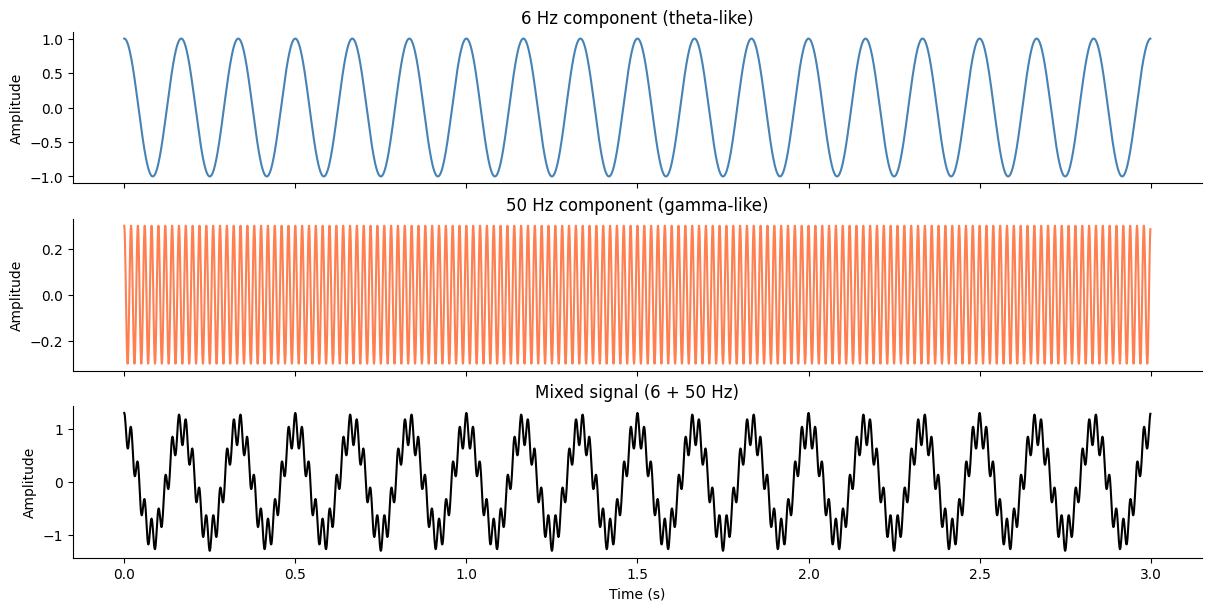

In [12]:
# Create a synthetic signal: 6 Hz + 50 Hz
synth_rate = 1000  # Hz
synth_duration = 3.0  # seconds — long enough for filtfilt with low-frequency FIR filters
t = np.arange(0, synth_duration, 1 / synth_rate)

signal_theta = 1.0 * np.cos(2 * np.pi * 6 * t)
signal_gamma = 0.3 * np.cos(2 * np.pi * 50 * t)
signal_mixed = signal_theta + signal_gamma

fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True, layout="constrained")

axes[0].plot(t, signal_theta, color="steelblue")
axes[0].set(ylabel="Amplitude", title="6 Hz component (theta-like)")

axes[1].plot(t, signal_gamma, color="coral")
axes[1].set(ylabel="Amplitude", title="50 Hz component (gamma-like)")

axes[2].plot(t, signal_mixed, color="black")
axes[2].set(xlabel="Time (s)", ylabel="Amplitude", title="Mixed signal (6 + 50 Hz)")

for ax in axes:
    ax.spines[["top", "right"]].set_visible(False)

### Designing an FIR Bandpass Filter

A filter is defined by its **difference equation** in the time domain:

$$y[n] = \sum_{k=0}^{M} b_k \, x[n-k] - \sum_{k=1}^{N} a_k \, y[n-k]$$

The first sum is a **weighted moving average** of the input (current and past
inputs). The second sum is an **autoregressive** term that feeds back past
outputs.

This gives two families of filters:

- **FIR (Finite Impulse Response)**: Only uses input terms ($a_k = 0$ for
  $k \geq 1$). The impulse response has finite length.
- **IIR (Infinite Impulse Response)**: Uses both input and feedback terms.
  The impulse response extends indefinitely (hence "infinite").

**FIR vs. IIR tradeoffs:**

| Property | FIR | IIR |
|----------|-----|-----|
| Phase response | Can be linear-phase (constant delay) | Frequency-dependent delay |
| Stability | Always stable | Can be unstable |
| Computational cost | Higher (longer filters) | Lower (fewer coefficients) |
| Steepness | Requires higher order for steep cutoff | Naturally steep cutoff |

For LFP analysis, **FIR filters** are generally preferred because linear
phase means the timing of different frequency components is preserved.

We'll use `scipy.signal.firwin` to design an FIR bandpass filter for the
theta band (4–12 Hz).

In [13]:
# Design an FIR bandpass filter for theta (4-12 Hz)
THETA_LOW = 4  # Hz
THETA_HIGH = 12  # Hz

# Number of taps: higher = steeper cutoff but longer time smearing
# Rule of thumb: at least 3 cycles of the lowest frequency
# For the synthetic demo we use a shorter filter so filtfilt works on short signals;
# for real LFP (many samples) we use a longer filter later
n_taps = 251  # ~250 ms at 1 kHz — good enough for demo

# firwin requires odd numtaps for a bandpass (pass_zero=False) filter
if n_taps % 2 == 0:
    n_taps += 1

# Design the FIR bandpass filter using a windowed sinc approach
fir_coeffs = firwin(
    n_taps,
    [THETA_LOW, THETA_HIGH],
    pass_zero=False,  # bandpass, not bandstop
    fs=synth_rate,
)

print(f"FIR filter length: {n_taps} taps ({n_taps / synth_rate * 1000:.0f} ms)")

FIR filter length: 251 taps (251 ms)


In [14]:
# Also design an IIR (Butterworth) bandpass for comparison
# IIR filters use feedback, so they can achieve steep cutoff with fewer coefficients
iir_order = 4
iir_sos = butter(iir_order, [THETA_LOW, THETA_HIGH], btype="band", fs=synth_rate, output="sos")

print(f"IIR Butterworth order: {iir_order}")

IIR Butterworth order: 4


### Visualizing the Frequency Response: FIR vs. IIR

Before applying a filter, always inspect its frequency response. This shows
how much each frequency is attenuated (or passed). Key characteristics:

- **Passband**: Frequencies that pass through with minimal attenuation
- **Stopband**: Frequencies that are strongly attenuated
- **Transition band**: The region between passband and stopband
- **Ripple**: Fluctuations in the passband gain
- **Roll-off**: How steeply the filter transitions from passband to stopband

Comparing FIR and IIR filters reveals a key tradeoff: the IIR filter
achieves a steeper roll-off with far fewer coefficients, but its **phase
response is nonlinear** — different frequencies are delayed by different
amounts. The FIR filter has a perfectly linear phase (constant delay),
which preserves timing relationships between frequency components.

/var/folders/86/m147b4k17lddvs_xsw0mj2zw0000gn/T/ipykernel_14266/383952213.py:10: RuntimeWarning: divide by zero encountered in log10
  ax.plot(freqs_iir, 20 * np.log10(np.abs(h_iir)), color="coral", label=f"IIR Butterworth (order {iir_order})")


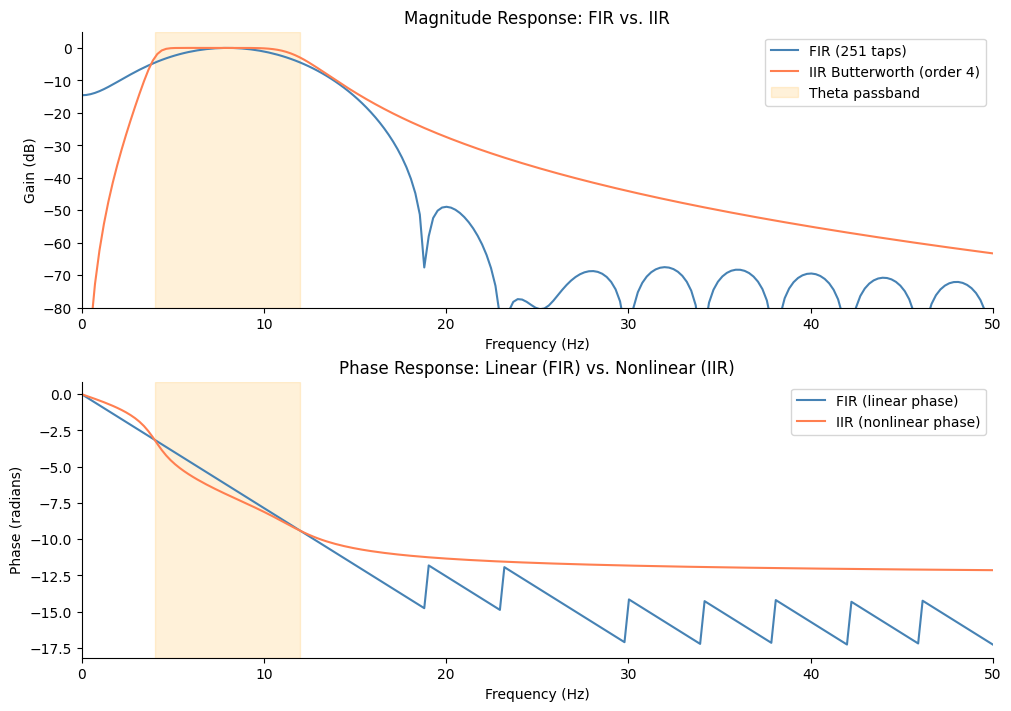

In [15]:
# Compute frequency responses for both filters
freqs_fir, h_fir = freqz(fir_coeffs, worN=2048, fs=synth_rate)
freqs_iir, h_iir = sosfreqz(iir_sos, worN=2048, fs=synth_rate)

fig, axes = plt.subplots(2, 1, figsize=(10, 7), layout="constrained")

# Magnitude response
ax = axes[0]
ax.plot(freqs_fir, 20 * np.log10(np.abs(h_fir)), color="steelblue", label="FIR (251 taps)")
ax.plot(freqs_iir, 20 * np.log10(np.abs(h_iir)), color="coral", label=f"IIR Butterworth (order {iir_order})")
ax.axvspan(THETA_LOW, THETA_HIGH, alpha=0.15, color="orange", label="Theta passband")
ax.set(
    xlabel="Frequency (Hz)",
    ylabel="Gain (dB)",
    title="Magnitude Response: FIR vs. IIR",
    xlim=(0, 50),
    ylim=(-80, 5),
)
ax.legend()
ax.spines[["top", "right"]].set_visible(False)

# Phase response — this is where FIR vs IIR differ most
ax = axes[1]
phase_fir = np.unwrap(np.angle(h_fir))
phase_iir = np.unwrap(np.angle(h_iir))
ax.plot(freqs_fir, phase_fir, color="steelblue", label="FIR (linear phase)")
ax.plot(freqs_iir, phase_iir, color="coral", label="IIR (nonlinear phase)")
ax.axvspan(THETA_LOW, THETA_HIGH, alpha=0.15, color="orange")
ax.set(
    xlabel="Frequency (Hz)",
    ylabel="Phase (radians)",
    title="Phase Response: Linear (FIR) vs. Nonlinear (IIR)",
    xlim=(0, 50),
)
ax.legend()
ax.spines[["top", "right"]].set_visible(False)

**Key observations:**

- **Magnitude** (top): Both filters pass 4–12 Hz and attenuate outside. The
  IIR filter has a steeper roll-off despite using far fewer coefficients.
- **Phase** (bottom): The FIR filter's phase is a straight line through the
  passband — a constant time delay at all frequencies. The IIR filter's phase
  is curved, meaning different frequencies experience different delays. This
  **frequency-dependent delay distorts the signal's waveform shape**.

This is why FIR filters are preferred for phase-sensitive analyses (e.g.,
extracting theta phase with the Hilbert transform). IIR filters are faster
to compute but require more care with phase interpretation.

### Causal vs. Zero-Phase Filtering

There are two ways to apply a filter:

**Causal filtering** (`scipy.signal.lfilter`):
- Output at time $t$ depends only on present and past input
- Introduces a phase delay (group delay)
- Required for real-time / closed-loop applications

**Zero-phase filtering** (`scipy.signal.filtfilt`):
- Applies the filter forward, then backward
- No phase distortion (the two passes cancel out the phase shift)
- Uses future samples — only works offline
- Effectively squares the magnitude response

**Rule of thumb:**
- Use **zero-phase** for offline LFP phase/amplitude analyses
- Use **causal** for real-time or when causal timing matters

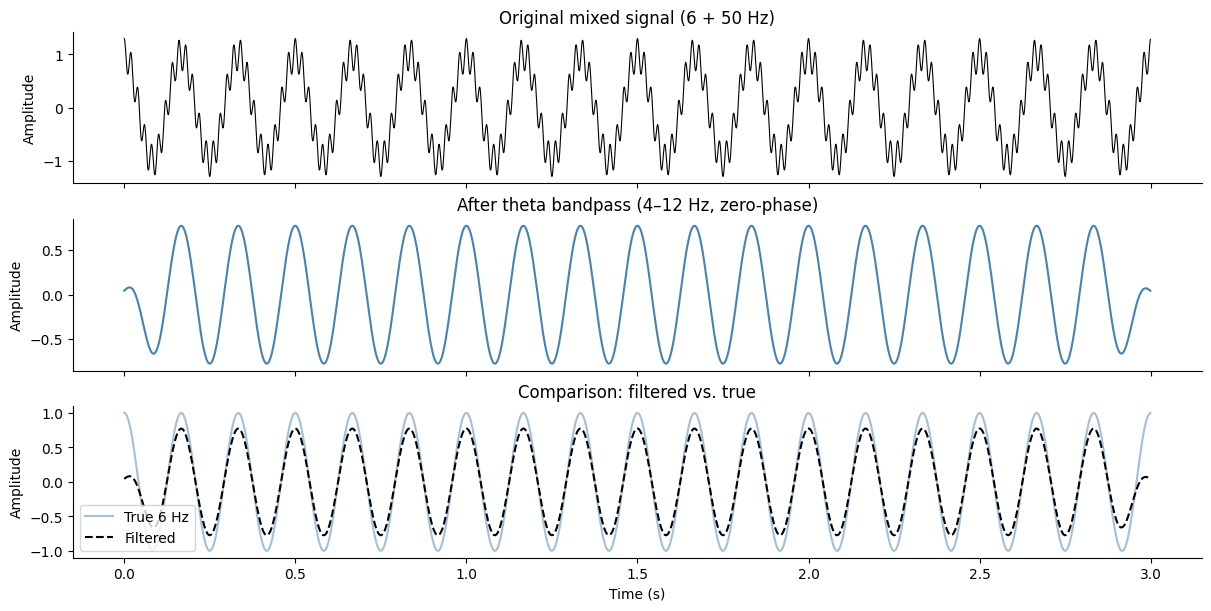

In [16]:
# Apply the theta filter to the synthetic signal
# Zero-phase filtering with filtfilt
filtered_synth = filtfilt(fir_coeffs, 1.0, signal_mixed)

fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True, layout="constrained")

axes[0].plot(t, signal_mixed, color="black", linewidth=0.8)
axes[0].set(ylabel="Amplitude", title="Original mixed signal (6 + 50 Hz)")

axes[1].plot(t, filtered_synth, color="steelblue")
axes[1].set(ylabel="Amplitude", title="After theta bandpass (4–12 Hz, zero-phase)")

axes[2].plot(t, signal_theta, color="steelblue", alpha=0.5, label="True 6 Hz")
axes[2].plot(t, filtered_synth, color="black", linestyle="--", label="Filtered")
axes[2].set(xlabel="Time (s)", ylabel="Amplitude", title="Comparison: filtered vs. true")
axes[2].legend()

for ax in axes:
    ax.spines[["top", "right"]].set_visible(False)

The bandpass filter successfully extracts the 6 Hz component and suppresses
the 50 Hz component. The filtered signal closely matches the original theta
component.

Note the brief distortions at the edges — these are **edge artifacts** from
the filter needing a "warm-up" period. In practice, load extra data at the
edges and trim after filtering.

### The Time–Frequency Tradeoff in Filtering

Filters face the same fundamental tradeoff as spectral analysis:

- **Narrow bandwidth** (e.g., 6–8 Hz) → highly selective in frequency, but
  the filter must "listen" for many cycles → poor time resolution (smearing)
- **Wide bandwidth** (e.g., 4–12 Hz) → less selective in frequency, but
  responds quickly to changes → good time resolution

This is because a filter's impulse response (its "memory") is longer for
narrower bandwidths. More memory means better frequency selectivity, but the
output at each time point averages over a longer chunk of signal.

Text(0.5, 0.98, 'Time–Frequency Tradeoff in Filter Design')

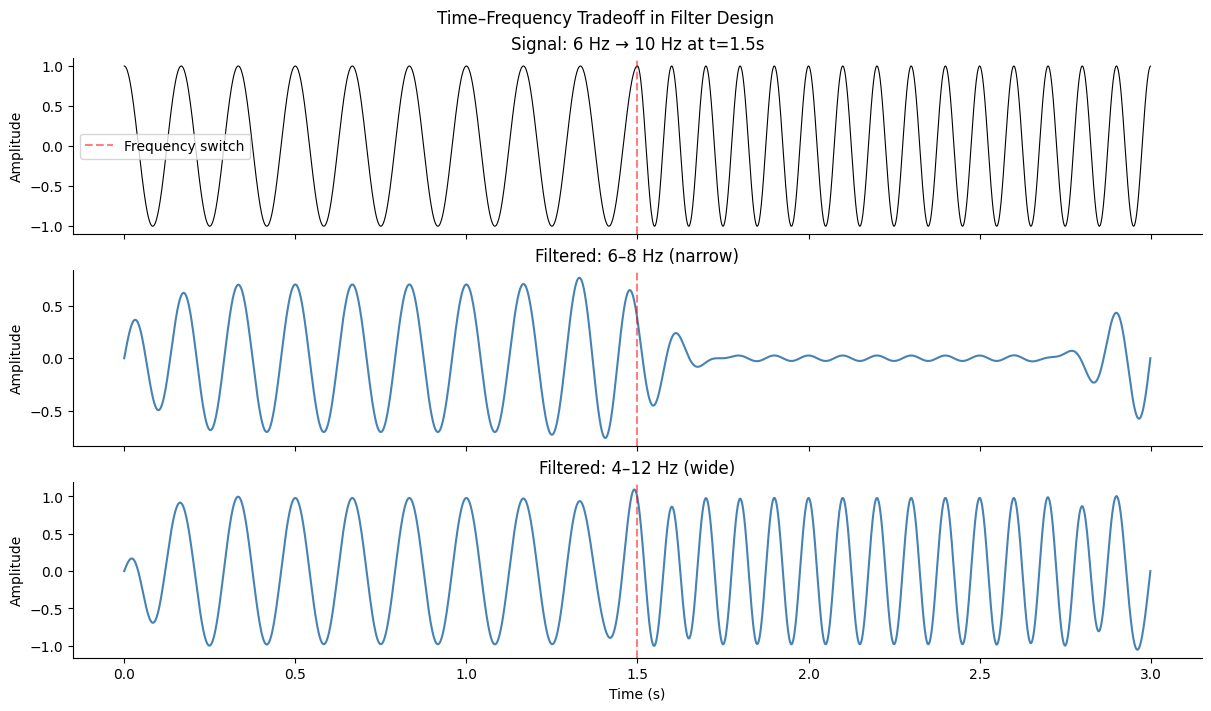

In [17]:
# Demonstrate the time-frequency tradeoff with different bandwidths
bandwidths = [(6, 8, "6–8 Hz (narrow)"), (4, 12, "4–12 Hz (wide)")]

fig, axes = plt.subplots(
    len(bandwidths) + 1, 1, figsize=(12, 7), sharex=True, layout="constrained",
)

# Create a signal with an abrupt frequency change at t=1.5s
t_demo = np.arange(0, 3.0, 1 / synth_rate)
# 6 Hz for first half, then 10 Hz for second half
signal_switch = np.where(
    t_demo < 1.5,
    np.cos(2 * np.pi * 6 * t_demo),
    np.cos(2 * np.pi * 10 * t_demo),
)

axes[0].plot(t_demo, signal_switch, color="black", linewidth=0.8)
axes[0].axvline(1.5, color="red", linestyle="--", alpha=0.5, label="Frequency switch")
axes[0].set(ylabel="Amplitude", title="Signal: 6 Hz → 10 Hz at t=1.5s")
axes[0].legend()

for ax, (low, high, label) in zip(axes[1:], bandwidths):
    n_filt = int(3 * synth_rate / low)
    if n_filt % 2 == 0:
        n_filt += 1
    coeffs = firwin(n_filt, [low, high], pass_zero=False, fs=synth_rate)
    # Use padlen to keep padding within signal length
    filtered = filtfilt(coeffs, 1.0, signal_switch, padlen=min(3 * (n_filt - 1), len(signal_switch) - 1))
    ax.plot(t_demo, filtered, color="steelblue")
    ax.axvline(1.5, color="red", linestyle="--", alpha=0.5)
    ax.set(ylabel="Amplitude", title=f"Filtered: {label}")

for ax in axes:
    ax.spines[["top", "right"]].set_visible(False)
axes[-1].set_xlabel("Time (s)")
fig.suptitle("Time–Frequency Tradeoff in Filter Design")

The narrow filter (6–8 Hz) is slow to respond to the frequency switch —
it smears the transition over many cycles. The wide filter (4–12 Hz) responds
faster but passes both 6 and 10 Hz, so both components are visible.

### Applying the Theta Filter to Real LFP

Now let's apply our theta bandpass filter to the real hippocampal LFP. We'll
use zero-phase filtering since this is an offline analysis and we want to
preserve phase information.

In [18]:
# Design a theta bandpass filter for the LFP sampling rate
n_taps_lfp = int(3 * lfp_rate / THETA_LOW)
if n_taps_lfp % 2 == 0:
    n_taps_lfp += 1

fir_coeffs_lfp = firwin(
    n_taps_lfp,
    [THETA_LOW, THETA_HIGH],
    pass_zero=False,
    fs=lfp_rate,
)

# Subtract mean before filtering (remove DC offset)
lfp_ch1_detrended = lfp_ch1 - np.mean(lfp_ch1)

# Apply zero-phase filter
lfp_theta = filtfilt(fir_coeffs_lfp, 1.0, lfp_ch1_detrended)

print(f"Filter length: {n_taps_lfp} taps ({n_taps_lfp / lfp_rate * 1000:.0f} ms)")

Filter length: 15001 taps (750 ms)


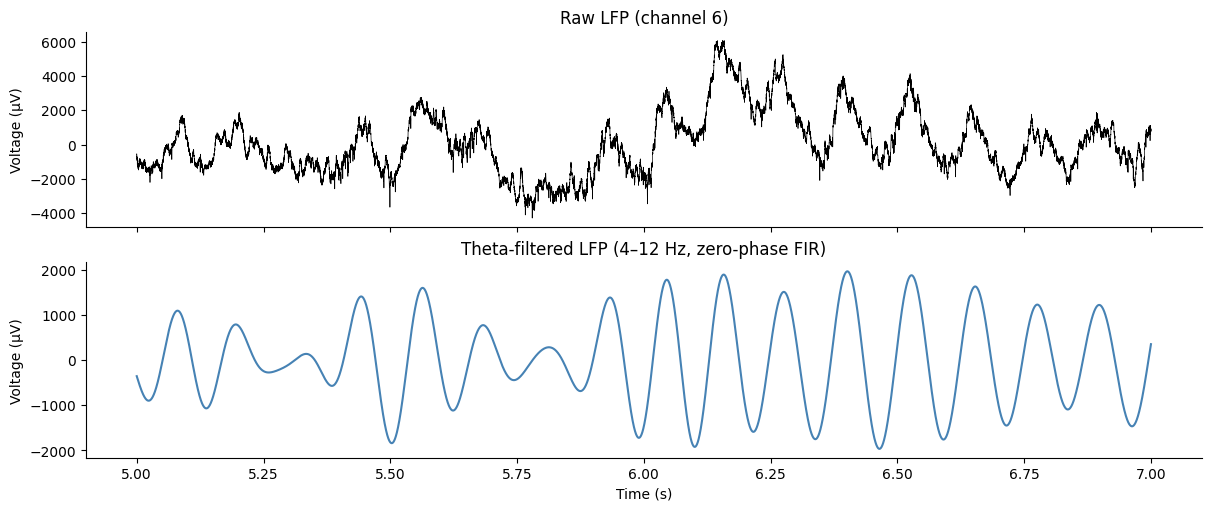

In [19]:
# Plot raw LFP and theta-filtered LFP
# Show a 2-second window to see individual theta cycles
PLOT_START = 5  # seconds
PLOT_DURATION = 2  # seconds
plot_mask = (lfp_time >= PLOT_START) & (lfp_time < PLOT_START + PLOT_DURATION)

fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True, layout="constrained")

ax = axes[0]
ax.plot(lfp_time[plot_mask], lfp_ch1[plot_mask], color="black", linewidth=0.5)
ax.set(ylabel="Voltage (µV)", title=f"Raw LFP (channel {theta_ref_channel})")
ax.spines[["top", "right"]].set_visible(False)

ax = axes[1]
ax.plot(lfp_time[plot_mask], lfp_theta[plot_mask], color="steelblue")
ax.set(
    xlabel="Time (s)",
    ylabel="Voltage (µV)",
    title="Theta-filtered LFP (4–12 Hz, zero-phase FIR)",
)
ax.spines[["top", "right"]].set_visible(False)

The theta rhythm is clearly visible in the filtered trace — a strong ~8 Hz
oscillation that is the hallmark of hippocampal activity during active
navigation.

## Part 2: Hilbert Transform and Instantaneous Phase/Amplitude

The Fourier transform gives us the *average* amplitude and the phase at the
beginning of a window. But we often want to know the **instantaneous** phase
and amplitude at each time point — for example, to ask whether a neuron fires
preferentially at a particular phase of the theta cycle.

The **Hilbert transform** solves this by converting a real-valued signal into
a **complex-valued analytic signal** that encodes both amplitude and phase at
every time point.

### The Three Steps

1. **Bandpass filter** the signal to isolate a single rhythm (phase is only
   meaningful for narrowband signals)
2. **Compute the analytic signal** using `scipy.signal.hilbert`
   (despite its name, this function computes the analytic signal, not the
   Hilbert transform itself)
3. **Extract phase and amplitude** from the complex analytic signal

### The Analytic Signal

For a real signal $x(t)$, the analytic signal is:

$$z(t) = x(t) + i \, \hat{x}(t)$$

where $\hat{x}(t)$ is the Hilbert transform of $x(t)$. In the frequency
domain, this is equivalent to zeroing out the negative frequencies and
doubling the positive frequencies.

From the complex analytic signal, we extract:

- **Instantaneous amplitude** (envelope): $A(t) = |z(t)|$
- **Instantaneous phase**: $\phi(t) = \arg(z(t))$

### Demonstration with Synthetic Signal

Let's first see how the Hilbert transform works on a signal where we know
the answer — a cosine that changes amplitude over time.

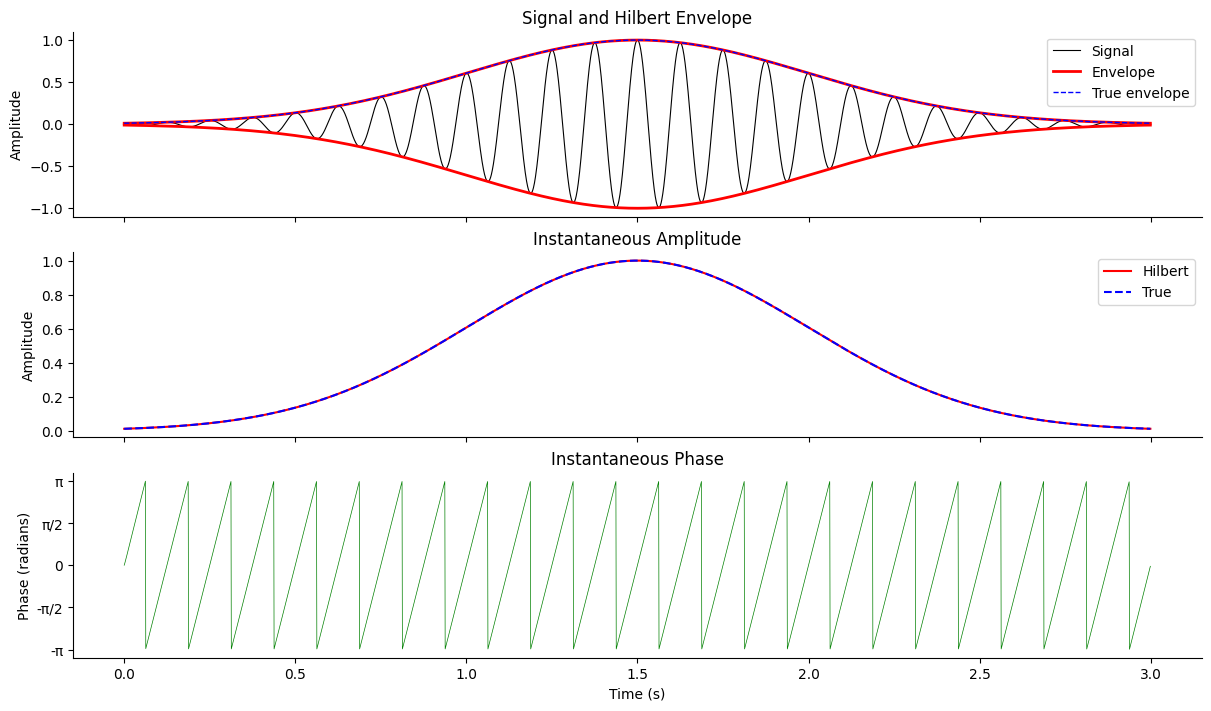

In [20]:
# Synthetic signal: 8 Hz cosine with time-varying amplitude
t_hilbert = np.arange(0, 3.0, 1 / synth_rate)

# Amplitude ramps up, then down
amplitude_envelope = np.exp(-0.5 * ((t_hilbert - 1.5) / 0.5) ** 2)
signal_modulated = amplitude_envelope * np.cos(2 * np.pi * 8 * t_hilbert)

# Compute analytic signal
analytic = hilbert(signal_modulated)

# Extract instantaneous amplitude and phase
inst_amplitude = np.abs(analytic)
inst_phase = np.angle(analytic)

fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True, layout="constrained")

# Signal with envelope
ax = axes[0]
ax.plot(t_hilbert, signal_modulated, color="black", linewidth=0.8, label="Signal")
ax.plot(t_hilbert, inst_amplitude, color="red", linewidth=2, label="Envelope")
ax.plot(t_hilbert, -inst_amplitude, color="red", linewidth=2)
ax.plot(t_hilbert, amplitude_envelope, color="blue", linewidth=1, linestyle="--", label="True envelope")
ax.set(ylabel="Amplitude", title="Signal and Hilbert Envelope")
ax.legend()
ax.spines[["top", "right"]].set_visible(False)

# Instantaneous amplitude
ax = axes[1]
ax.plot(t_hilbert, inst_amplitude, color="red", label="Hilbert")
ax.plot(t_hilbert, amplitude_envelope, color="blue", linestyle="--", label="True")
ax.set(ylabel="Amplitude", title="Instantaneous Amplitude")
ax.legend()
ax.spines[["top", "right"]].set_visible(False)

# Instantaneous phase
ax = axes[2]
ax.plot(t_hilbert, inst_phase, color="green", linewidth=0.5)
ax.set(
    xlabel="Time (s)",
    ylabel="Phase (radians)",
    title="Instantaneous Phase",
    yticks=[-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi],
    yticklabels=["-π", "-π/2", "0", "π/2", "π"],
)
ax.spines[["top", "right"]].set_visible(False)

The Hilbert envelope (red) closely tracks the true amplitude modulation
(blue dashed). The instantaneous phase advances linearly at the oscillation
frequency (8 Hz), wrapping from $\pi$ to $-\pi$ each cycle.

**Key intuition**: Think of the Hilbert transform as a coordinate
transformation from a 1D time series to a 2D complex time series. The real
part is the original signal; the imaginary part is a 90°-shifted copy. This
gives us a "phasor" that rotates in the complex plane — its angle is the
instantaneous phase, and its distance from the origin is the instantaneous
amplitude.

### Extracting Theta Phase and Amplitude from Real LFP

Now let's apply this pipeline to the real hippocampal LFP:
1. We already have the theta-filtered signal from Part 1
2. Compute the analytic signal with `scipy.signal.hilbert`
3. Extract phase and amplitude

In [21]:
# Compute analytic signal of the theta-filtered LFP
theta_analytic = hilbert(lfp_theta)
theta_amplitude = np.abs(theta_analytic)
theta_phase = np.angle(theta_analytic)

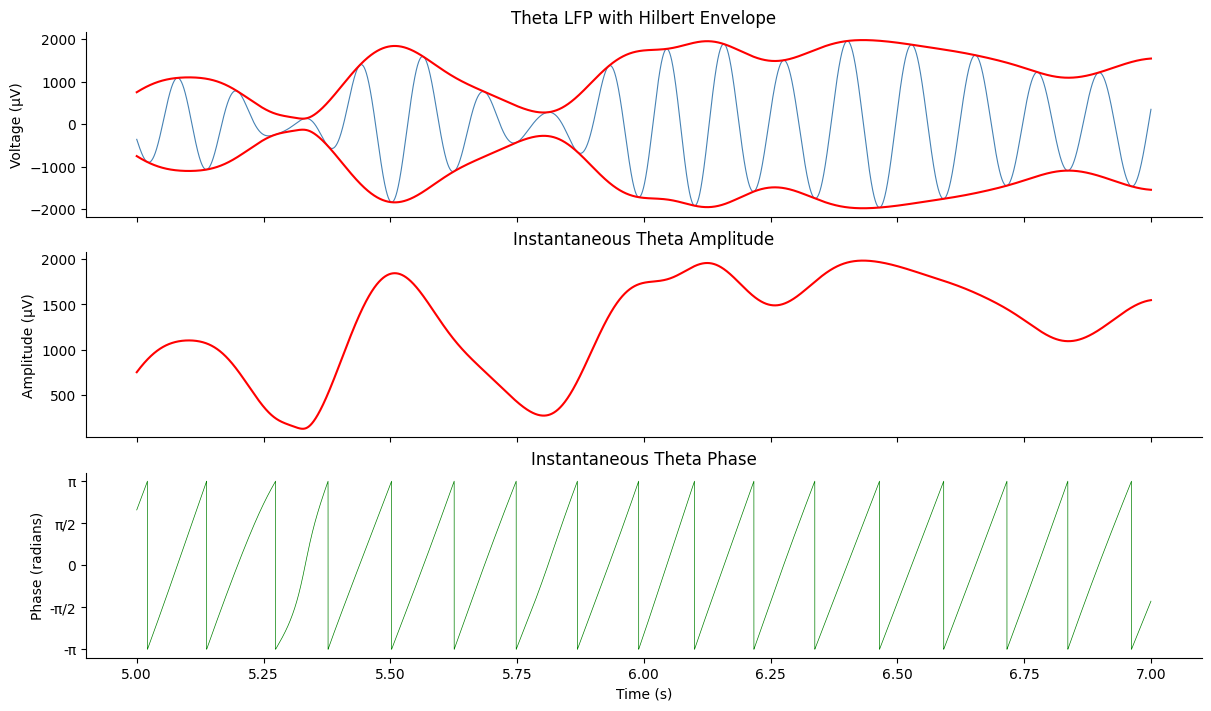

In [22]:
# Plot theta-filtered LFP with instantaneous amplitude and phase
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True, layout="constrained")

# Theta LFP with envelope
ax = axes[0]
ax.plot(lfp_time[plot_mask], lfp_theta[plot_mask], color="steelblue", linewidth=0.8)
ax.plot(lfp_time[plot_mask], theta_amplitude[plot_mask], color="red", linewidth=1.5)
ax.plot(lfp_time[plot_mask], -theta_amplitude[plot_mask], color="red", linewidth=1.5)
ax.set(ylabel="Voltage (µV)", title="Theta LFP with Hilbert Envelope")
ax.spines[["top", "right"]].set_visible(False)

# Instantaneous amplitude (theta power)
ax = axes[1]
ax.plot(lfp_time[plot_mask], theta_amplitude[plot_mask], color="red")
ax.set(ylabel="Amplitude (µV)", title="Instantaneous Theta Amplitude")
ax.spines[["top", "right"]].set_visible(False)

# Instantaneous phase
ax = axes[2]
ax.plot(lfp_time[plot_mask], theta_phase[plot_mask], color="green", linewidth=0.5)
ax.set(
    xlabel="Time (s)",
    ylabel="Phase (radians)",
    title="Instantaneous Theta Phase",
    yticks=[-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi],
    yticklabels=["-π", "-π/2", "0", "π/2", "π"],
)
ax.spines[["top", "right"]].set_visible(False)

The amplitude envelope captures the waxing and waning of theta power —
theta is strongest during active movement and weakens during pauses. The
phase advances monotonically through each theta cycle, providing a "clock"
signal that other neural events can be referenced to.

This is the foundation for **theta phase coding**: the idea that the timing
of spikes relative to the theta cycle carries information beyond just firing
rate.

### Theta Power Over Time

Let's look at how theta amplitude varies over the full 60-second segment and
compare it to the animal's running speed. Theta power is known to increase
during active locomotion.

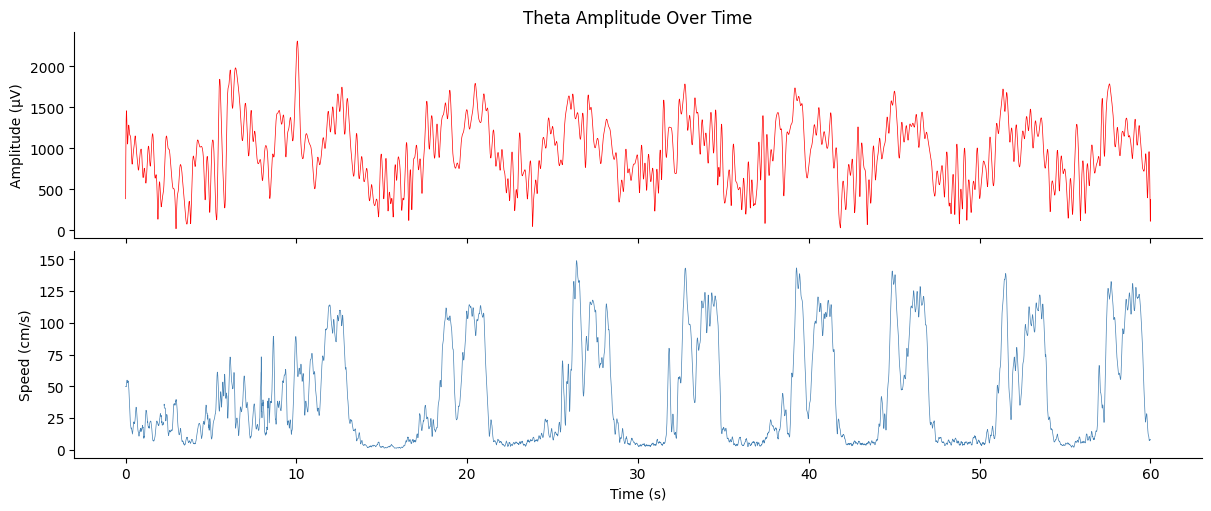

In [23]:
# Plot theta amplitude and speed over the full segment
speed_offset = speed_timestamps[0]
speed_relative = speed_timestamps - speed_offset

fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True, layout="constrained")

# Theta amplitude
ax = axes[0]
ax.plot(lfp_time, theta_amplitude, color="red", linewidth=0.5)
ax.set(ylabel="Amplitude (µV)", title="Theta Amplitude Over Time")
ax.spines[["top", "right"]].set_visible(False)

# Speed
ax = axes[1]
speed_mask_full = speed_relative < ANALYSIS_DURATION
if speed_mask_full.any():
    ax.plot(
        speed_relative[speed_mask_full],
        speed_data[speed_mask_full],
        linewidth=0.5,
        color="steelblue",
    )
ax.set(xlabel="Time (s)", ylabel=f"Speed ({speed_interface.unit})")
ax.spines[["top", "right"]].set_visible(False)

## Part 3: Spectral Coherence

So far we've analyzed single LFP channels. But the brain is a network, and
a key question is: **how do oscillations relate across different brain
regions?**

**Spectral coherence** measures the consistency of the phase relationship
between two signals at each frequency, across multiple observations (trials
or time windows). It answers: *is there a stable phase relationship between
signals $x$ and $y$ at frequency $f$?*

### Definition

Coherence at frequency $f_j$ is defined as:

$$\kappa_{xy,j} = \frac{|\langle S_{xy,j} \rangle|}{\sqrt{\langle S_{xx,j} \rangle} \sqrt{\langle S_{yy,j} \rangle}}$$

where:
- $S_{xy,j}$ is the **cross-spectrum** at frequency $f_j$ (like the power
  spectrum, but between two signals)
- $S_{xx,j}$ and $S_{yy,j}$ are the **auto-spectra** (power spectra of each
  signal)
- $\langle \cdot \rangle$ denotes averaging across trials (or time windows
  / tapers)

### Intuition: Phase Consistency

The cross-spectrum $S_{xy,j} = X_j Y_j^*$ captures both the amplitudes and
the phase difference between the two signals at frequency $j$. In polar
coordinates:

$$S_{xy,j} = A_j B_j \exp(i\Phi_j)$$

where $\Phi_j = \phi_j - \theta_j$ is the phase difference.

When we average the cross-spectrum across trials:
- If the **phase difference is consistent** across trials, the complex
  exponentials add constructively → $|\langle S_{xy} \rangle|$ is large →
  **high coherence** (close to 1)
- If the **phase difference is random** across trials, the complex
  exponentials cancel out → $|\langle S_{xy} \rangle|$ is small →
  **low coherence** (close to 0)

So coherence measures **phase consistency**, normalized to lie between 0 and 1.

### Demonstrating Coherence with Synthetic Signals

Let's build intuition with two examples:
1. Two signals with a **constant phase offset** → high coherence
2. Two signals with **random phase offsets** across trials → low coherence

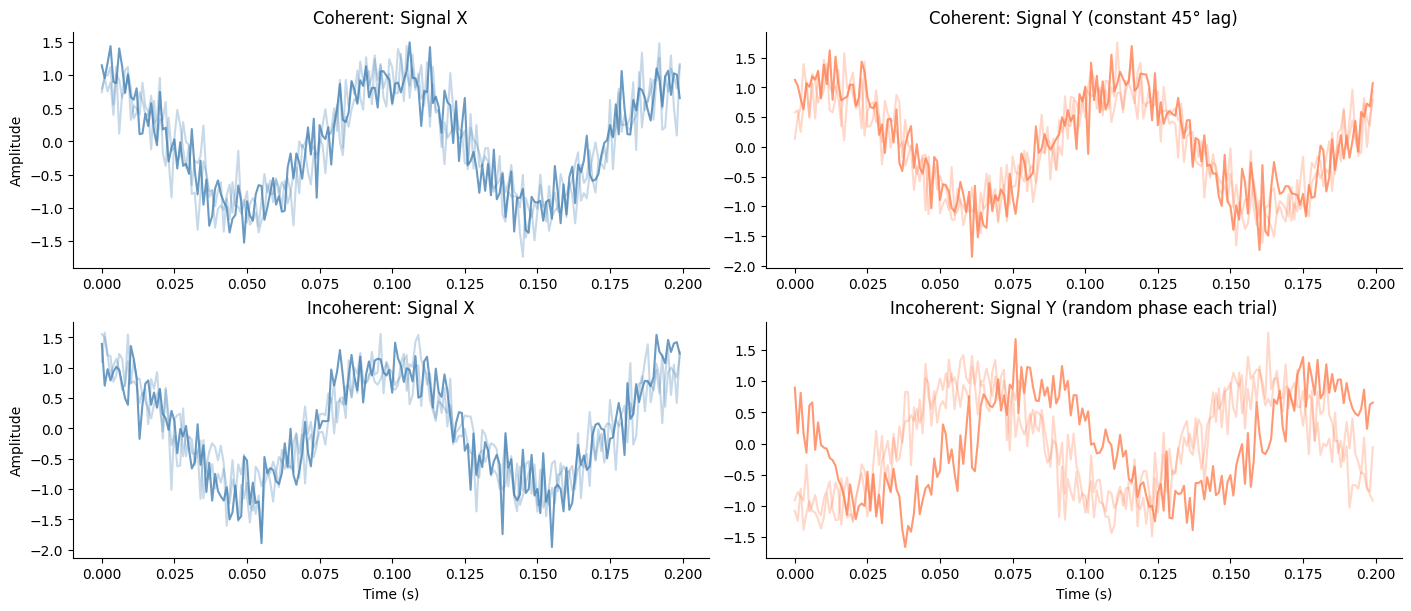

In [24]:
# Example 1: Constant phase relationship (high coherence)
n_trials = 20
trial_duration = 1.0  # seconds
t_trial = np.arange(0, trial_duration, 1 / synth_rate)
n_samples = len(t_trial)

# Signal x: 10 Hz cosine with slight noise
# Signal y: 10 Hz cosine with a constant 45° phase lag plus noise
np.random.seed(42)
noise_level = 0.3

signals_coherent_x = np.zeros((n_trials, n_samples))
signals_coherent_y = np.zeros((n_trials, n_samples))

constant_phase_lag = np.pi / 4  # 45 degrees

for k in range(n_trials):
    signals_coherent_x[k] = np.cos(2 * np.pi * 10 * t_trial) + noise_level * np.random.randn(n_samples)
    signals_coherent_y[k] = np.cos(2 * np.pi * 10 * t_trial - constant_phase_lag) + noise_level * np.random.randn(n_samples)

# Example 2: Random phase relationship (low coherence)
signals_random_x = np.zeros((n_trials, n_samples))
signals_random_y = np.zeros((n_trials, n_samples))

for k in range(n_trials):
    random_phase = 2 * np.pi * np.random.rand()  # random phase each trial
    signals_random_x[k] = np.cos(2 * np.pi * 10 * t_trial) + noise_level * np.random.randn(n_samples)
    signals_random_y[k] = np.cos(2 * np.pi * 10 * t_trial - random_phase) + noise_level * np.random.randn(n_samples)

# Plot a few trials of each
fig, axes = plt.subplots(2, 2, figsize=(14, 6), layout="constrained")

for k in range(3):
    alpha = 0.8 if k == 0 else 0.3
    axes[0, 0].plot(t_trial[:200], signals_coherent_x[k, :200], color="steelblue", alpha=alpha)
    axes[0, 1].plot(t_trial[:200], signals_coherent_y[k, :200], color="coral", alpha=alpha)
    axes[1, 0].plot(t_trial[:200], signals_random_x[k, :200], color="steelblue", alpha=alpha)
    axes[1, 1].plot(t_trial[:200], signals_random_y[k, :200], color="coral", alpha=alpha)

axes[0, 0].set(title="Coherent: Signal X", ylabel="Amplitude")
axes[0, 1].set(title="Coherent: Signal Y (constant 45° lag)")
axes[1, 0].set(title="Incoherent: Signal X", xlabel="Time (s)", ylabel="Amplitude")
axes[1, 1].set(title="Incoherent: Signal Y (random phase each trial)", xlabel="Time (s)")

for ax in axes.flat:
    ax.spines[["top", "right"]].set_visible(False)

### Computing Coherence with the `spectral_connectivity` Package

The `spectral_connectivity` package computes multitaper coherence, which
treats each taper as an independent "trial" (in addition to any actual trials
or time windows). This gives reliable coherence estimates even from
continuous data.

In [25]:
# Compute coherence for the coherent signals
# Stack x and y as two "signals": shape (n_samples, n_trials, n_signals)
coherent_data = np.stack(
    [signals_coherent_x.T, signals_coherent_y.T], axis=-1
)  # (n_samples, n_trials, 2)

mt_coherent = Multitaper(
    coherent_data,
    sampling_frequency=synth_rate,
    time_halfbandwidth_product=4,
)
conn_coherent = Connectivity.from_multitaper(mt_coherent)
coh_coherent = conn_coherent.coherence_magnitude()
coh_freqs = conn_coherent.frequencies

# Compute coherence for the random-phase signals
random_data = np.stack(
    [signals_random_x.T, signals_random_y.T], axis=-1
)

mt_random = Multitaper(
    random_data,
    sampling_frequency=synth_rate,
    time_halfbandwidth_product=4,
)
conn_random = Connectivity.from_multitaper(mt_random)
coh_random = conn_random.coherence_magnitude()

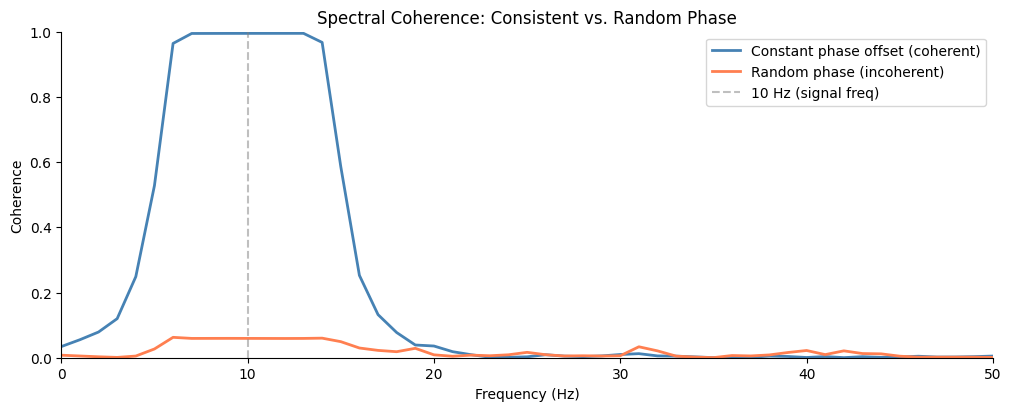

In [26]:
# Plot coherence for both cases
fig, ax = plt.subplots(figsize=(10, 4), layout="constrained")

# Coherence is between signal 0 and signal 1
ax.plot(
    coh_freqs,
    coh_coherent[:, :, 0, 1].squeeze(),
    color="steelblue",
    linewidth=2,
    label="Constant phase offset (coherent)",
)
ax.plot(
    coh_freqs,
    coh_random[:, :, 0, 1].squeeze(),
    color="coral",
    linewidth=2,
    label="Random phase (incoherent)",
)

ax.axvline(10, color="gray", linestyle="--", alpha=0.5, label="10 Hz (signal freq)")
ax.set(
    xlabel="Frequency (Hz)",
    ylabel="Coherence",
    title="Spectral Coherence: Consistent vs. Random Phase",
    xlim=(0, 50),
    ylim=(0, 1),
)
ax.legend()
ax.spines[["top", "right"]].set_visible(False)

The coherent signals (blue) show high coherence (~1) at 10 Hz — the
frequency where they share a consistent phase relationship. The incoherent
signals (red) show low coherence because the phase relationship changes
randomly across trials.

Coherence at other frequencies is low for both cases because the noise is
independent between signals.

### Key Properties of Coherence

| Value | Interpretation |
|-------|---------------|
| $\kappa_{xy} \approx 1$ | Strong, consistent phase relationship at frequency $f$ |
| $\kappa_{xy} \approx 0$ | No consistent phase relationship at frequency $f$ |
| Intermediate values | Partial phase consistency (e.g., noisy coupling) |

Coherence does **not** tell you *what* the phase offset is — only that it
is consistent. Two signals can have high coherence with any phase offset
(0°, 90°, 180°, etc.), as long as the offset is the same across trials.

### Computing Coherence Between LFP Channels

Now let's apply coherence analysis to the real hippocampal LFP. We'll compute
coherence between two electrode channels to see at which frequencies their
activity is coordinated.

For continuous data (no trial structure), we use the multitaper approach:
- The multiple DPSS tapers provide independent spectral estimates
- Each taper acts as an independent "trial" for the coherence computation
- Overlapping time windows can provide additional averaging

In [27]:
# Prepare the two-channel LFP data for coherence analysis
# Detrend both channels
lfp_ch1_detrended = lfp_ch1 - np.mean(lfp_ch1)
lfp_ch2_detrended = lfp_ch2 - np.mean(lfp_ch2)

# Stack as (n_samples, 1_trial, 2_signals)
lfp_two_channel = np.stack(
    [lfp_ch1_detrended, lfp_ch2_detrended], axis=-1
)[:, np.newaxis, :]

# Compute multitaper coherence
mt_lfp = Multitaper(
    lfp_two_channel,
    sampling_frequency=lfp_rate,
    time_halfbandwidth_product=4,
    time_window_duration=1.0,  # 1-second windows for averaging
    time_window_step=0.5,  # 50% overlap
    detrend_type="constant",
)

conn_lfp = Connectivity.from_multitaper(mt_lfp)
lfp_coherence = conn_lfp.coherence_magnitude()
lfp_coh_freqs = conn_lfp.frequencies

# Average coherence across time windows
mean_coherence = np.mean(lfp_coherence[:, :, 0, 1], axis=0)

print(f"Coherence shape: {lfp_coherence.shape}")
print(f"Time windows: {lfp_coherence.shape[0]}")
print(f"Frequency bins: {len(lfp_coh_freqs)}")

Coherence shape: (119, 10001, 2, 2)
Time windows: 119
Frequency bins: 10001


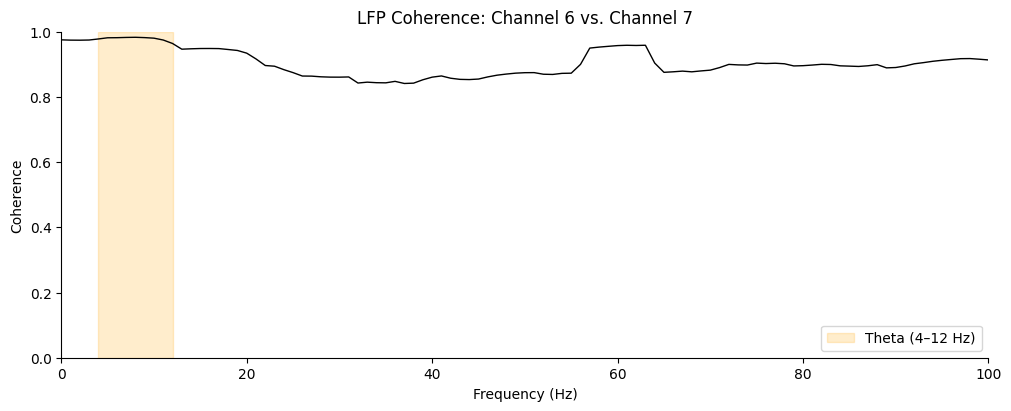

In [28]:
# Plot coherence between the two LFP channels
fig, ax = plt.subplots(figsize=(10, 4), layout="constrained")

ax.plot(lfp_coh_freqs, mean_coherence, color="black", linewidth=1)
ax.axvspan(4, 12, alpha=0.2, color="orange", label="Theta (4–12 Hz)")
ax.set(
    xlabel="Frequency (Hz)",
    ylabel="Coherence",
    title=f"LFP Coherence: Channel {theta_ref_channel} vs. Channel {second_channel}",
    xlim=(0, 100),
    ylim=(0, 1),
)
ax.legend()
ax.spines[["top", "right"]].set_visible(False)

Nearby channels on the same probe typically show high coherence at low
frequencies and decreasing coherence at higher frequencies. The theta band
often has particularly high coherence, reflecting the large-scale synchronous
theta oscillation that spans the hippocampal network.

### Time-Resolved Coherence (Coherogram)

Just as a spectrogram shows how power changes over time, a **coherogram**
shows how coherence changes over time. This reveals dynamic changes in
inter-channel coupling — for example, coherence might increase during
specific behavioral states.

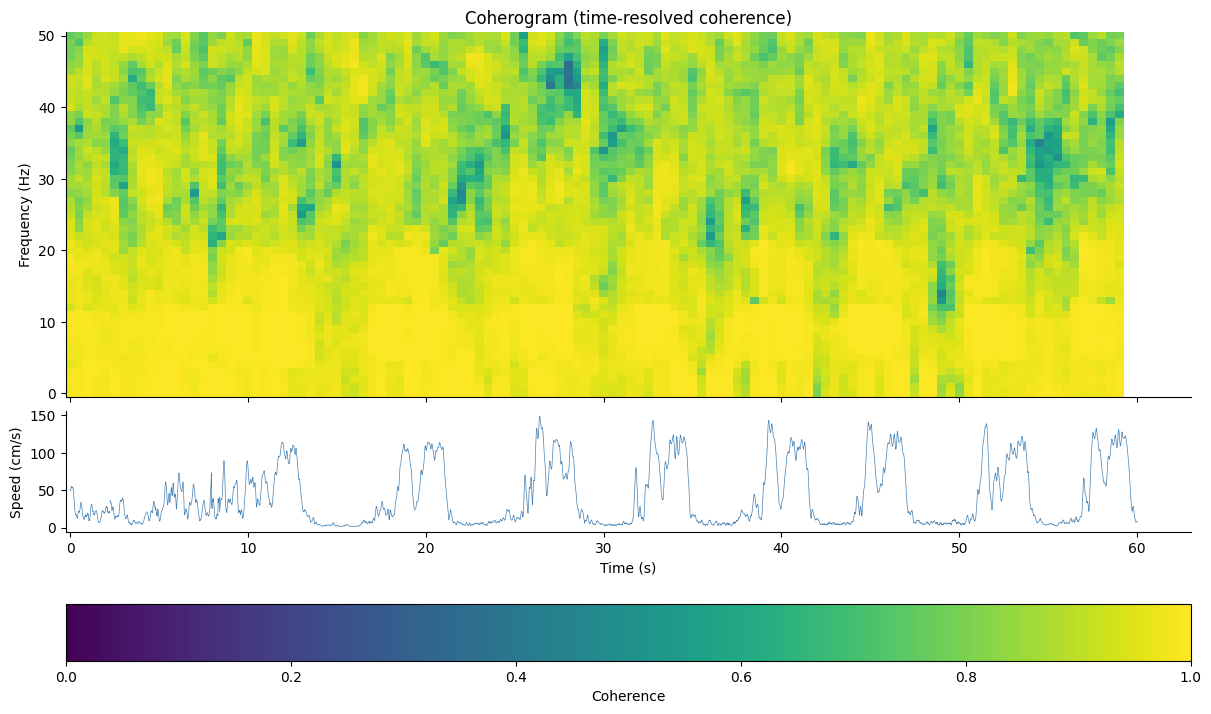

In [29]:
# Plot coherogram (coherence over time and frequency)
freq_limit = 50  # Hz
freq_mask = lfp_coh_freqs <= freq_limit
coh_time = mt_lfp.time

fig, axes = plt.subplots(
    2, 1, figsize=(12, 7), sharex=True, layout="constrained",
    gridspec_kw={"height_ratios": [3, 1]},
)

# Coherogram
ax = axes[0]
mesh = ax.pcolormesh(
    coh_time,
    lfp_coh_freqs[freq_mask],
    lfp_coherence[:, freq_mask, 0, 1].T,
    shading="auto",
    cmap="viridis",
    vmin=0,
    vmax=1,
)
ax.set(ylabel="Frequency (Hz)", title="Coherogram (time-resolved coherence)")
ax.spines[["top", "right"]].set_visible(False)

# Speed overlay
ax = axes[1]
if speed_mask_full.any():
    ax.plot(
        speed_relative[speed_mask_full],
        speed_data[speed_mask_full],
        linewidth=0.5,
        color="steelblue",
    )
ax.set(xlabel="Time (s)", ylabel=f"Speed ({speed_interface.unit})")
ax.spines[["top", "right"]].set_visible(False)

fig.colorbar(mesh, ax=axes.tolist(), location="bottom", label="Coherence", pad=0.05)

## Exercises

Try these on your own to deepen your understanding:

1. **IIR filtering in practice**: We compared the FIR and IIR frequency
   responses above. Now apply the IIR Butterworth filter to the real LFP
   using zero-phase filtering (`sosfiltfilt`) and compare the filtered
   waveform to the FIR result. Do you notice differences in the theta
   waveform shape?
   (Hint: `from scipy.signal import sosfiltfilt`;
   `lfp_theta_iir = sosfiltfilt(iir_sos, lfp_ch1_detrended)`)

2. **Filter order**: Try different FIR filter orders (e.g., 1, 3, and 5
   cycles of the lowest frequency). How does this affect the frequency
   response and the filtered signal?

3. **Other frequency bands**: Apply bandpass filters for other hippocampal
   rhythms and extract their amplitude envelopes:
   - Gamma (30–80 Hz)
   - Ripples (100–250 Hz) — you may need to look during immobility periods

4. **Theta-gamma coupling**: Bandpass filter the LFP for theta and gamma
   separately. Extract the theta phase and gamma amplitude. Is gamma
   amplitude modulated by theta phase? (This is called cross-frequency
   coupling.)

5. **Channel distance and coherence**: Compute coherence between channel
   pairs at different spatial separations on the probe. How does coherence
   in the theta band change with distance?

6. **Coherence during running vs. rest**: Separate the LFP into running
   (speed > 4 cm/s) and rest (speed < 1 cm/s) epochs. Compare theta
   coherence between the two states. Is coherence higher during running?

## Summary

In this notebook, we learned how to:

1. **Design and apply bandpass filters** to isolate specific frequency bands
2. **Distinguish FIR vs. IIR filters** and their tradeoffs
3. **Apply zero-phase filtering** for offline phase-preserving analysis
4. **Understand the time–frequency tradeoff** in filter design
5. **Extract instantaneous phase and amplitude** using the Hilbert transform
6. **Compute spectral coherence** between two LFP signals
7. **Interpret coherence** as a measure of phase consistency

### Key Concepts

| Concept | Description |
|---------|-------------|
| Bandpass filter | Passes frequencies in a specified range, attenuates all others |
| FIR filter | Uses only input samples; can have linear phase (constant delay) |
| IIR filter | Uses input and past output; computationally efficient but nonlinear phase |
| Zero-phase filtering | Forward-backward filtering; no phase distortion (offline only) |
| Time–frequency tradeoff | Narrow bandwidth → good frequency selectivity, poor time resolution |
| Analytic signal | Complex signal $z(t) = x(t) + i\hat{x}(t)$ from Hilbert transform |
| Instantaneous amplitude | $A(t) = \|z(t)\|$ — the signal envelope |
| Instantaneous phase | $\phi(t) = \arg(z(t))$ — the oscillation phase at each time point |
| Spectral coherence | Phase consistency between two signals at each frequency (0 to 1) |
| Cross-spectrum | $S_{xy} = X Y^*$ — Fourier product between two signals |

### Python Techniques Used

- **`scipy.signal.firwin`** for FIR bandpass filter design
- **`scipy.signal.butter`** for IIR Butterworth filter design
- **`scipy.signal.filtfilt`** for zero-phase filtering
- **`scipy.signal.freqz`** and **`scipy.signal.sosfreqz`** for inspecting frequency responses
- **`scipy.signal.hilbert`** for computing the analytic signal
- **`spectral_connectivity.Connectivity`** for multitaper coherence

### Next Steps

In notebook 04, we'll move from analyzing LFP to **decoding** — using neural
activity (both spikes and LFP) to reconstruct the animal's position. This
connects the neural representations we've characterized to computational
models of spatial coding.

## Cleanup

In [30]:
# Close file handles
behavior_io.close()
lfp_io.close()